In [1]:
import numpy as np
import pandas as pd
import csv
#from sklearn import datasets,decomposition
import matplotlib.pyplot as plt 
from os      import system
#import seaborn as sns
import py3Dmol
import mdtraj
from IPython.display import display,HTML

In [2]:
def dataref(data,maxfix=10,county=1000,maxrot=120):
#step I 
#replace zeros to nan
#del collums with data less than county
#then del rows from beginning&end until met rows with whole data
    for i in data:
        if i.endswith('pos'):
            data[i][data[i]==0]=np.nan
    for i in data:
        if i.endswith('pos') and data.count()[i]<county:
            data=data.drop([i],axis=1)
            data=data.drop([i[:-3]+'rad'],axis=1)
            data=data.drop([i[:-3]+'ang'],axis=1)
            print('del collums:',i[:-3])
    outrange=[0,data.shape[0]-1]
    while True:
        switch=0
        for i in data:
            if i.endswith('pos') and np.isnan(data[i][outrange[0]]):
                outrange[0]+=1
                switch=1
                break
        if switch==0:
            break
    while True:
        switch=0
        for i in data:
            if i.endswith('pos') and np.isnan(data[i][outrange[1]]):
                outrange[1]-=1
                switch=1
                break
        if switch==0:
            break
    print('select data:',outrange)
    data=data[outrange[0]:outrange[1]+1].copy()    
#step II fix data with zero position values
    data.reset_index(drop=True)
    lmax=len(data)
    added=0
    for i in data:
        if i.endswith('pos')==False:
            continue
        f=0
        while f<lmax:
            if np.isnan(data[i][f])==False:
                up=[data[i][f],data[i[:-3]+'rad'][f],data[i[:-3]+'ang'][f]]
                down=(0,0,0)
                f+=1
            else:
                count=0
                while(np.isnan(data[i][f])):    
                    count+=1
                    f+=1
                if count>maxfix:
                    raise ValueError("too many missing data in row",i,f)
                down=[data[i][f],data[i[:-3]+'rad'][f],data[i[:-3]+'ang'][f]]
                if down[2]-up[2]>180:
                    up[2]+=360
                elif down[2]-up[2]<-180:
                    up[2]-=360
                s=[(down[0]-up[0])/(count+1),(down[1]-up[1])/(count+1),(down[2]-up[2])/(count+1)]
                for c in range(1,count+1):
                    data[i][f-c]=down[0]-c*s[0]
                    data[i[:-3]+'rad'][f-c]=down[1]-c*s[1]
                    data[i[:-3]+'ang'][f-c]=down[2]-c*s[2]
                    print('add data ',i[:-3],f-c,data[i][f-c],data[i[:-3]+'rad'][f-c],data[i[:-3]+'ang'][f-c])
                    added+=1
    print('total data added:',added)
#step III fix data with rotation more than 180 degree between frames
    warn=0
    for i in data:
        if i.endswith('ang')==False:
            continue
        encircle=0
        for f in range(1,lmax):
            da=data[i][f]-data[i][f-1]-360*encircle
            if da%360>maxrot and da%360<(360-maxrot):
                warn+=1
                data[i][f]=data[i][f-1]
                print('WARNING',warn,': ',i,' rotated ',da,' degree at frame ',f)
                continue
            elif da>maxrot:
#                print(i[:-3],' encircle +1 with DNA at frame ',f)
                encircle+=1
            elif da<-maxrot:
#                print(i[:-3],' encircle -1 with DNA at frame ',f)
                encircle-=1
            data[i][f]-=360*encircle
    return data
def dataunity(data):
    posstd=0
    radstd=0
    angstd=0
    for i in data:
        if i.endswith('pos'):
            posstd+=data[i].std()
        elif i.endswith('rad'):
            radstd+=data[i].std()
        elif i.endswith('ang'):
            angstd+=data[i].std()
    for i in data:
        if i.endswith('pos'):
            data[i]/=(posstd*3/len(data.columns))
        elif i.endswith('rad'):
            data[i]/=(radstd*3/len(data.columns))
        elif i.endswith('ang'):
            data[i]/=(angstd*3/len(data.columns))
    return data
def data_average(data,window=100):
    ld=len(data)-window
    adata=data[:1-window].copy(deep=True)
    for i in adata:
        temp=(data[i][window:].values-data[i][:-window].values)/window
        adata[i][0]=adata[i][:window].mean()
        for f in range(0,ld):
            adata[i][f+1]=adata[i][f]+temp[f]
#        print(i)
    return adata
def data_diff(data,diff=1):
    ddata=data[:-diff].copy(deep=True)
    for i in ddata:
        ddata[i]=data[i][:-diff].values-data[i][diff:].values
    return ddata

In [3]:
def genheatmat(datax,datay,hx=10,hy=10):
    if len(datax)!=len(datay):
        print('two lines do not match!')    
    histx=(datax.max()-datax.min())/hx
    histy=(datay.max()-datay.min())/hy
    minx=datax.min()
    miny=datay.min()
    lx=len(datax)
    heatmap=np.zeros([hx+1,hy+1])
    for i in range(lx):
        heatmap[int((datax[i]-minx)//histx)][int((datay[i]-miny)//histy)]+=1
    return heatmap

(10901,)

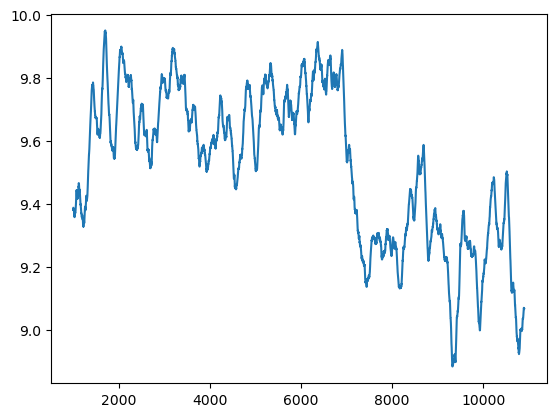

In [1]:
jupyter labextension install jupyterlab_3dmol

SyntaxError: invalid syntax (2043168009.py, line 1)

/tmp/ipykernel_29338/2230616416.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata[i][0]=adata[i][:window].mean()


0.9847275198795091 16.67232213844616


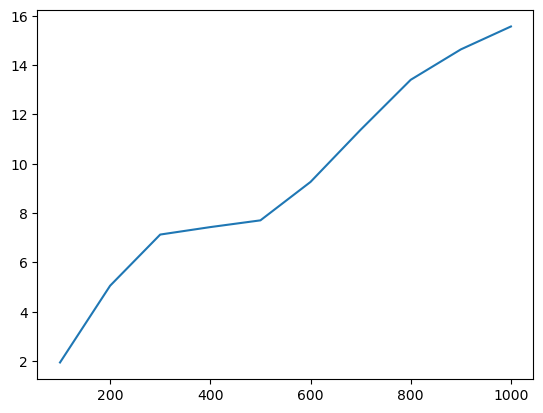

In [17]:
#data_ini=pd.read_csv("/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/ligamd/ligamd_3_prod.csv")
#data_ini=pd.read_csv("/media/pangpang/removeable_1/PCNA/cmd_rep1_prod.csv")
#data_ini=pd.read_csv("/media/pangpang/quzhi/GapR_slide_summary/10gc_5at/cmd202110/cmd202110_prod.csv")
#data_ini=pd.read_csv('/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/cmd2111/cmd_prod.csv')
#data_ini=pd.read_csv('/media/pangpang/quzhi/PCNA_slide_summary/cmd_1M_rep1/6_/PCNA_1M.csv')
data=data_average(data_ini,100)
#pos=np.asarray(data['ALL859ALLpos'][:5000-500])
pos=np.asarray(data['ALLpos'][0:3000])
dtlist=list(range(100,1100,100))
msd=[]
std=[]
for dt in dtlist:
    l=len(pos)
    dev=pos[:-dt]-pos[dt:]
    msd.append((dev*dev).mean())
    std.append((dev*dev).std())
#print(np.polyfit(dtlist,msd,1))
print(np.corrcoef(dtlist,msd)[0][1],1156*np.std(msd)/np.std(dtlist))
plt.plot(dtlist,msd)
pd.DataFrame({'msd':msd,'std':std}).to_csv("ligamd_3.csv")
#pos1=pos
#plt.plot(pos)

In [70]:
np.absolute((dev**2-(dev**2).mean())).mean()

0.06409147933773864

(array([5582., 1111.,  183.,  237.,  195.,  258.,   91.,  195.,  109.,
          40.]),
 array([2.25000000e-08, 4.72931493e-02, 9.45862760e-02, 1.41879403e-01,
        1.89172530e-01, 2.36465656e-01, 2.83758783e-01, 3.31051910e-01,
        3.78345037e-01, 4.25638163e-01, 4.72931290e-01]),
 <BarContainer object of 10 artists>)

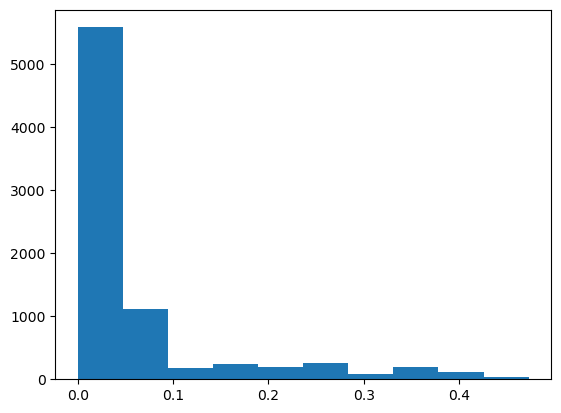

In [71]:
plt.hist(dev**2)

In [4]:
#analysis PCA
data_ini=pd.read_csv('/media/pangpang/quzhi/GapR_slide_summary/10gc_5at/cmd202110/cmd202110_detail.csv')
#data_ini=pd.read_csv('/media/pangpang/quzhi/GapR_slide_summary/10at_5gc/cmd2111/cmd_prod2.csv')
#data=pd.read_csv('/media/pangpang/data_ex1/10AT_5GCend/hpc/cmd_from_ligamd/7/download/atcmd_li7.csv')
data=data_ini.drop(columns=data_ini.columns[0:4])
data=data.iloc[1000:2000].reset_index().drop(columns='index')
#data=data.iloc[7000:7500].reset_index().drop(columns='index')
#print(data.shape)
#for i in data:
#    if i.endswith('da') or i.endswith('dr') or i.endswith('dp'):
#        data=data.drop([i],axis=1)
print(data.shape)
#data=data.drop(['Unnamed: 0'],axis=1)
data=dataref(data,data.shape[0]/100,data.shape[0]*0.8)
print(data.shape)
adata=data_average(data,100)
#pd.DataFrame(adata).to_csv('curvesatcmd_2.csv')
rdata=adata.copy(deep=True)
for i in data:
    rdata[i]=rdata[i]/rdata[i].std()
#dataunity(data)
covmat=np.cov(rdata,rowvar=False)
evalue,evec=np.linalg.eig(covmat)
outdata=np.matmul(rdata,evec)

(1000, 48)
select data: [0, 999]
total data added: 0
(1000, 48)


48.000000000000014
0.4506729622508978
0.2561933893853616
0.11895406599955217
0.050800156300185084
0.04451692891387225
0.03352891848049203
0.018905835158970874
0.00808384061967604
0.005734875975743274
0.003934197406340118
0.0025485799511597617
0.0019341909365960155
0.0014231335238465699
0.0009779860250554327
0.00048232901774339
0.000348409011818829
0.0002538440763388624
0.00017940297811862104
0.00012683917999888346
8.720887988870374e-05
6.782274850692734e-05
5.4884785958830345e-05
4.197506640114461e-05
3.244410820022227e-05
2.3833576295431437e-05
1.8859432363970585e-05
1.3771310733950512e-05
1.2621601683108091e-05
9.389987125973489e-06
7.512917932446396e-06
6.32163566174194e-06
5.854028182574517e-06
3.652974490154095e-06
3.2560133638425836e-06
2.617571780500315e-06
1.667503207887831e-06
1.449595845648324e-06
1.071103360734284e-06
1.0488224861824347e-06
7.599732431176606e-07
5.665523350696099e-07
4.944404053719636e-07
3.477677917896286e-07
2.512054932728169e-07
1.887220028186271e-07
4.70

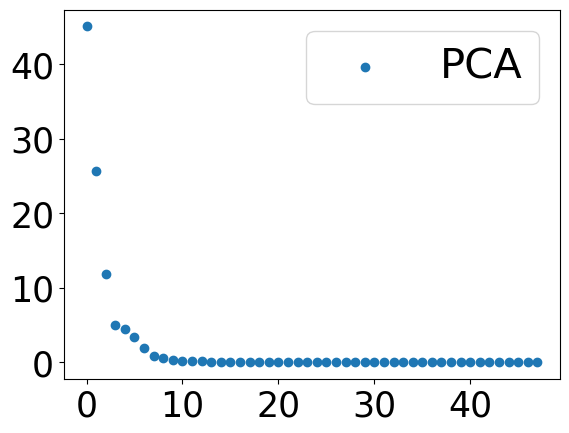

In [5]:
print(evalue.sum())
for i in evalue:
    print(i/evalue.sum())
fig,ax = plt.subplots()
ax.scatter(list(range(48)),100*evalue/evalue.sum())
plt.xticks(fontsize=25) 
plt.yticks(fontsize=25) 
lgd=plt.legend(['PCA'],fontsize=30)

In [6]:
#overall
modelname="pdb/10gc5at.pdb"
nevec=0
size=[200,0,0]
system="".join([x for x in open(modelname)])
pdb=mdtraj.load(modelname)
Pcoord=pdb.xyz[0][pdb.topology.select('name P')]
center=Pcoord.mean(axis=0)
_,_,vv=np.linalg.svd(Pcoord-center)
dir_p=vv[0]
dir_r=np.zeros([16,3])
dir_t=np.zeros([16,3])
oris=np.zeros([16,3])
ends=np.zeros([16,3])

view=py3Dmol.view(width=400,height=300)
view.addModel(system)
#view.setStyle({'model':-1,'resi':list(range(1,41))},{})
view.setStyle({'model':-1,'resi':list(range(1,41))},{"cartoon":{"color":"black"}})
view.setStyle({'model':-1,'resi':list(range(41,119))},{"cartoon":{"color":"yellow"}})
view.setStyle({'model':-1,'resi':list(range(119,197))},{"cartoon":{"color":"blue"}})
view.setStyle({'model':-1,'resi':list(range(197,275))},{"cartoon":{"color":"cyan"}})
view.setStyle({'model':-1,'resi':list(range(275,353))},{"cartoon":{"color":"green"}})

oris[0]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 43 to 62')))
oris[1]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 121 to 140')))
oris[2]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 199 to 218')))
oris[3]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 277 to 296')))
oris[4]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 63 to 80')))
oris[5]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 141 to 158')))
oris[6]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 219 to 236')))
oris[7]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 297 to 314')))
oris[8]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 84 to 95')))
oris[9]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 162 to 173')))
oris[10]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 240 to 251')))
oris[11]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 318 to 329')))
oris[12]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 98 to 115')))
oris[13]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 176 to 193')))
oris[14]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 254 to 271')))
oris[15]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 332 to 349')))
oris=oris*10
average_r=rdata.to_numpy().mean(axis=0).reshape(16,3)[:,1]

for i in range(16):
    dp=vv[0]*0.34*evec[:,nevec].reshape(16,3)[i,0]
    dir_r[i]=np.cross(np.cross(dir_p,oris[i]-center),dir_p)
    dir_r[i]=dir_r[i]/(dir_r[i]*dir_r[i]).sum()
    dr=dir_r[i]*evec[:,nevec].reshape(16,3)[i,1]
    dir_t[i]=np.cross(dir_r[i],dir_p,)
    dt=average_r[i]*dir_t[i]*evec[:,nevec].reshape(16,3)[i,2]
    ends[i]=oris[i]+dp*size[0]+dr*size[1]+dt*size[2]
    view.addArrow({'start':{'x':oris[i,0],'y':oris[i,1],'z':oris[i,2]},
                   'end':{'x':ends[i,0],'y':ends[i,1],'z':ends[i,2]},
                   'radius':1,'color':'red'})
view.zoomTo()
view.show()
#view.png()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
modelname="pdb/10gc5at.pdb"
system="".join([x for x in open(modelname)])
view=py3Dmol.view(width=400,height=300)
view.addModel(system)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
#cut
modelname="../10AT_5GCend.pdb"
nevec=0
size=[200,0,0]
system="".join([x for x in open(modelname)])
pdb=mdtraj.load(modelname)
Pcoord=pdb.xyz[0][pdb.topology.select('name P')]
center=Pcoord.mean(axis=0)
_,_,vv=np.linalg.svd(Pcoord-center)
dir_p=vv[0]
dir_r=np.zeros([16,3])
dir_t=np.zeros([16,3])
oris=np.zeros([16,3])
ends=np.zeros([16,3])

view=py3Dmol.view(width=400,height=300)
view.addModel(system)
#view.setStyle({'model':-1,'resi':list(range(1,41))},{})
view.setStyle({'model':-1,'resi':list(range(1,41))},{"cartoon":{"color":"black"}})
view.setStyle({'model':-1,'resi':list(range(41,119))},{"cartoon":{"color":"yellow"}})
view.setStyle({'model':-1,'resi':list(range(119,197))},{"cartoon":{"color":"blue"}})
view.setStyle({'model':-1,'resi':list(range(197,275))},{"cartoon":{"color":"cyan"}})
view.setStyle({'model':-1,'resi':list(range(275,353))},{"cartoon":{"color":"green"}})

oris[0]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 43 to 62')))
oris[1]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 121 to 140')))
oris[2]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 199 to 218')))
oris[3]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 277 to 296')))
oris[4]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 63 to 80')))
oris[5]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 141 to 158')))
oris[6]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 219 to 236')))
oris[7]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 297 to 314')))
oris[8]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 84 to 95')))
oris[9]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 162 to 173')))
oris[10]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 240 to 251')))
oris[11]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 318 to 329')))
oris[12]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 98 to 115')))
oris[13]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 176 to 193')))
oris[14]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 254 to 271')))
oris[15]=mdtraj.compute_center_of_mass(pdb.atom_slice(pdb.topology.select('resid 332 to 349')))
oris=oris*10
average_r=rdata.to_numpy().mean(axis=0).reshape(16,3)[:,1]

for i in range(16):
    dp=vv[0]*0.34*evec[:,nevec].reshape(16,3)[i,0]
    dir_r[i]=np.cross(np.cross(dir_p,oris[i]-center),dir_p)
    dir_r[i]=dir_r[i]/(dir_r[i]*dir_r[i]).sum()
    dr=dir_r[i]*evec[:,nevec].reshape(16,3)[i,1]
    dir_t[i]=np.cross(dir_r[i],dir_p,)
    dt=average_r[i]*dir_t[i]*evec[:,nevec].reshape(16,3)[i,2]
    ends[i]=oris[i]+dp*size[0]+dr*size[1]+dt*size[2]
    view.addArrow({'start':{'x':oris[i,0],'y':oris[i,1],'z':oris[i,2]},
                   'end':{'x':ends[i,0],'y':ends[i,1],'z':ends[i,2]},
                   'radius':1,'color':'red'})
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [77]:
average_r

array([40.83614324, 43.6956796 , 40.18374685, 63.09183086, 24.15617476,
       24.37452955, 44.87191446, 17.96095574, 28.23909492, 30.47440527,
       26.85678678, 33.81055456, 29.30555134, 27.81286912, 23.89518414,
       22.82845642])

(array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 [Text(0, -0.2, '−0.2'),
  Text(0, -0.1, '−0.1'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.10000000000000003, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.3, '0.3'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6')])

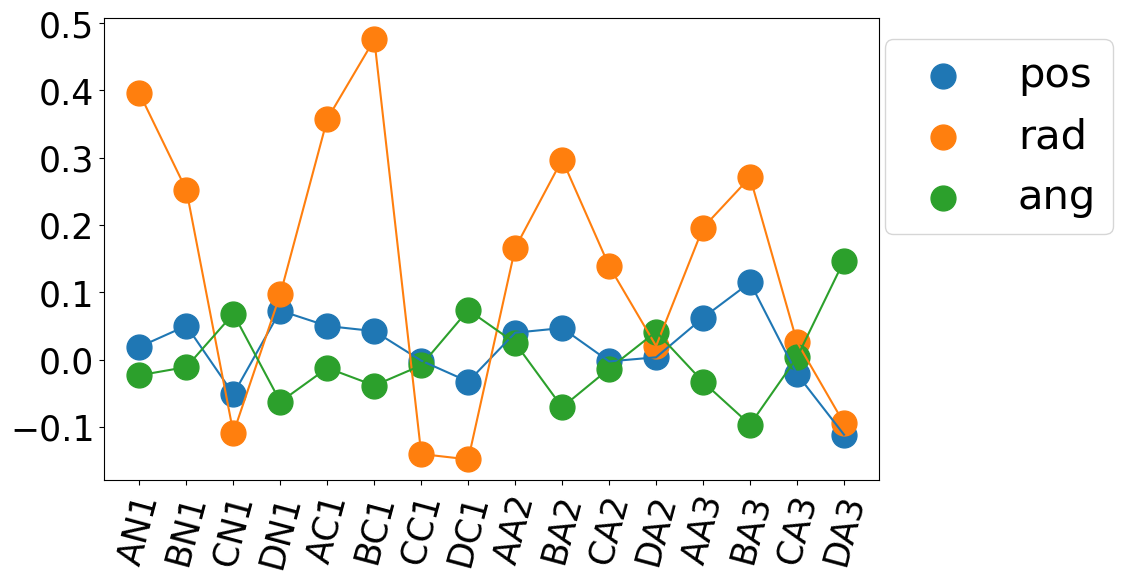

In [67]:
#draw 
k=5
labels=['AN1','BN1','CN1','DN1','AC1','BC1','CC1','DC1','AA2','BA2','CA2','DA2','AA3','BA3','CA3','DA3']
pos=np.zeros((len(evec)//3,len(evec)))
rad=np.zeros((len(evec)//3,len(evec)))
ang=np.zeros((len(evec)//3,len(evec)))
for i in range(len(evec)):
    if i%3==0:
        pos[i//3]=evec[i]
    elif i%3==1:
        rad[i//3]=evec[i]
    else:
        ang[i//3]=evec[i]
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(labels,pos[:,k],s=320,label='pos')
ax.scatter(labels,rad[:,k],s=320,label='rad')
ax.scatter(labels,ang[:,k],s=320,label='ang')
lgnd = plt.legend(['pos','rad','ang'],bbox_to_anchor=(0.98, 1), loc=2,fontsize=30)
ax.plot(labels,pos[:,k],label='pos')
ax.plot(labels,rad[:,k],label='rad')
ax.plot(labels,ang[:,k],label='ang')
plt.xticks(fontsize=25,rotation=75) 
plt.yticks(fontsize=25) 


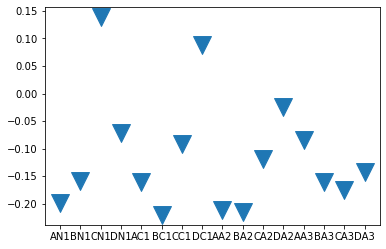

In [14]:
plt.scatter(labels,pos[:,k],s=320,label='pos',marker='v')

In [350]:
ca=np.zeros(len(posevec))
cb=np.zeros(len(posevec))
cc=np.zeros(len(posevec))
cd=np.zeros(len(posevec))
for i in range(len(posevec)):
    for j in range(len(posevec[i])):
        if j<8:
            ca[i]+=posevec[i][j]*posevec[i][j]
        elif j<16 and j>=8:
            cb[i]+=posevec[i][j]*posevec[i][j]
        elif j<24 and j>=16:
            cc[i]+=posevec[i][j]*posevec[i][j]
        else:
            cd[i]+=posevec[i][j]*posevec[i][j]

In [27]:
x=len(covmat)//3
s=0
for i in range(0,x):
    s+=covmat[i*3,i*3+2]
    print(covmat[i*3,i*3+2])
print(s/x)

-0.1775198505171214
-0.9742648453961104
-0.9778993822773152
-0.9454050525569498
-0.9392500395488739
-0.9600559582333752
-0.5019569335270192
-0.9561727610429095
-0.9355705378198965
-0.9772624995727761
-0.9357198859583437
-0.9642414258200724
-0.9667951625741931
-0.9600557176907069
0.02636469453087099
-0.9741776281849598
-0.8199989366368594


In [51]:
#rdata=adata.copy(deep=True)
covmat=np.cov(rdata[20000:27001],rowvar=False)
evalue,evec=np.linalg.eig(covmat)
outdata=np.matmul(rdata,evec)

In [148]:
#adata=data_average(data,100)
ddata=data_diff(data[3000:6001].reset_index(drop=True),10)
drdata=ddata.copy(deep=True)
for i in drdata:
    drdata[i]=drdata[i]/drdata[i].std()
#dataunity(drdata)
covmat=np.cov(drdata,rowvar=False)
evalue,evec=np.linalg.eig(covmat)
outdata=np.matmul(drdata,evec)

In [6]:
heat=genheatmat(outdata[1],outdata[0],30,30)

<AxesSubplot:>

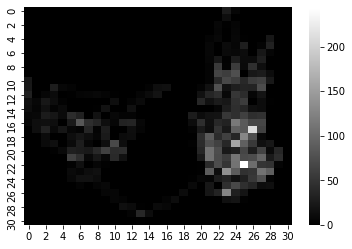

In [7]:
sns.heatmap(heat,cmap='gray')

In [4]:
#analysis tICA
tlag=10
data=pd.read_csv('curvesatcmd_reduced2.csv')
print(data.shape)
for i in data:
    if i.endswith('da') or i.endswith('dr') or i.endswith('dp'):
        data=data.drop([i],axis=1)
print(data.shape)
data=data.drop(['Unnamed: 0'],axis=1)
data=dataref(data,50)
print(data.shape)
adata=data_average(data,100)
#pd.DataFrame(adata).to_csv('curvesatcmd_2.csv')
rdata=adata.copy(deep=True)
for i in data:
    rdata[i]=rdata[i]/rdata[i].std()
#dataunity(data)
covmat=np.cov(rdata,rowvar=False)
tlagacmat=np.cov(rdata,rowvar=False)
evalue,evec=np.linalg.eig(covmat)
outdata=np.matmul(rdata,evec)

(25002, 49)
(25002, 49)
select data: [0, 10000]
total data added: 0
(10001, 48)


In [184]:
deffnm="'/media/pangpang/data_ex1/10AT_5GCend/hpc/cmd_from_ligamd/7/download/atcmd_li7"
pd.DataFrame(adata).to_csv(deffnm+'_averaged.csv')
#pd.DataFrame(covmat).to_csv(deffnm+'_covmat.csv')
#pd.DataFrame(evec).to_csv(deffnm+'_evec.csv')
#pd.DataFrame(outdata).to_csv(deffnm+'_model.csv')

OSError: Cannot save file into a non-existent directory: ''/media/pangpang/data_ex1/10AT_5GCend/hpc/cmd_from_ligamd/7/download'